# Random Survival Forest

In [2]:
%pip install lifelines scikit-survival numpy pandas joblib multiprocess scikit-learn imbalanced-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Random Survival Forest (RSF)
-----------------------------
Input: (X, time, event)
Output: Survival function S(t|X)

1. Choose hyperparameters
2. For each tree b in 1..B:
   a. Bootstrap sample data
   b. Grow survival tree:
      - Random feature subset
      - Split using log-rank test
   c. In each leaf, compute Kaplan-Meier S_b(t)
3. To predict:
   a. For each tree, drop X down → get S_b(t)
   b. Average across trees → S(t|X)
4. Derive median, expected, or thresholded survival

In [3]:
# Constant
EVENT = "Status"
DURATION =  "Survival Months"

In [4]:
# Splitting
from sksurv import compare, util
import numpy as np


def _find_split(node):
    """
    Find the best split for a Node.
    :param node: Node to find best split for.
    :return: score of best split, value of best split, variable to split, left indices, right indices.
    """
    score_opt = 0
    split_val_opt = None
    lhs_idxs_opt = None
    rhs_idxs_opt = None
    split_var_opt = None
    for i in node.f_idxs:
        score, split_val, lhs_idxs, rhs_idxs = _find_best_split_for_variable(node, i)

        if score > score_opt:
            score_opt = score
            split_val_opt = split_val
            lhs_idxs_opt = lhs_idxs
            rhs_idxs_opt = rhs_idxs
            split_var_opt = i

    return score_opt, split_val_opt, split_var_opt, lhs_idxs_opt, rhs_idxs_opt


def _find_best_split_for_variable(node, var_idx):
    """
    Find best split for a variable of a Node. Best split for a variable is the split with the highest log rank
    statistics. The logrank_test function of the lifelines package is used here.
    :param node: Node
    :param var_idx: Index of variable
    :return: score, split value, left indices, right indices.
    """
    score, split_val, lhs_idxs, rhs_idxs = logrank_statistics(
        x=node.x, y=node.y, feature=var_idx, min_leaf=node.min_leaf
    )
    return score, split_val, lhs_idxs, rhs_idxs


def logrank_statistics(x, y, feature, min_leaf):
    """
    Compute logrank_test of liflines package.
    :param x: Input samples
    :param y: Labels
    :param feature: Feature index
    :param min_leaf: Minimum number of leafs for each split.
    :return: best score, best split value, left indices, right indices
    """
    x_feature = x.reset_index(drop=True).iloc[:, feature]
    score_opt = 0
    split_val_opt = None
    lhs_idxs = None
    rhs_idxs = None

    unique_vals = np.sort(np.unique(x_feature))

    for split_val in unique_vals:
        feature1 = np.where(x_feature <= split_val)[0]
        feature2 = np.where(x_feature > split_val)[0]

        if len(feature1) < min_leaf or len(feature2) < min_leaf:
            continue

        y_tmp = y.iloc[np.concatenate((feature1, feature2)), :2]
        y_tmp["group_indicator"] = np.nan
        y_tmp.iloc[feature1, -1] = 0
        y_tmp.iloc[feature2, -1] = 1

        try:
            score, p_value = compare.compare_survival(
                util.Surv.from_dataframe(
                    EVENT, DURATION, y_tmp.drop(columns="group_indicator")
                ),
                y_tmp.loc[:, "group_indicator"],
                return_stats=False,
            )
        except ValueError:
            continue
        if score > score_opt:
            score_opt = round(score, 3)
            split_val_opt = round(split_val, 3)
            lhs_idxs = feature1
            rhs_idxs = feature2

    return score_opt, split_val_opt, lhs_idxs, rhs_idxs

In [5]:
# Scoring

from itertools import combinations


def concordance_index(y_time, y_pred, y_event):
    """
    Compute concordance index.
    :param y_time: Actual Survival Times.
    :param y_pred: Predicted cumulative hazard functions.
    :param y_event: Actual Survival Events.
    :return: c-index.
    """
    predicted_outcome = [x.sum() for x in y_pred]
    possible_pairs = list(combinations(range(len(y_pred)), 2))
    concordance = 0
    permissible = 0
    for pair in possible_pairs:
        t1 = y_time.iat[pair[0]]
        t2 = y_time.iat[pair[1]]
        e1 = y_event.iat[pair[0]]
        e2 = y_event.iat[pair[1]]
        predicted_outcome_1 = predicted_outcome[pair[0]]
        predicted_outcome_2 = predicted_outcome[pair[1]]

        shorter_survival_time_censored = (t1 < t2 and e1 == 0) or (t2 < t1 and e2 == 0)
        t1_equals_t2_and_no_death = (t1 == t2 and (e1 == 0 and e2 == 0))

        if shorter_survival_time_censored or t1_equals_t2_and_no_death:
            continue
        else:
            permissible = permissible + 1
            if t1 != t2:
                if t1 < t2:
                    if predicted_outcome_1 > predicted_outcome_2:
                        concordance = concordance + 1
                        continue
                    elif predicted_outcome_1 == predicted_outcome_2:
                        concordance = concordance + 0.5
                        continue
                elif t2 < t1:
                    if predicted_outcome_2 > predicted_outcome_1:
                        concordance = concordance + 1
                        continue
                    elif predicted_outcome_2 == predicted_outcome_1:
                        concordance = concordance + 0.5
                        continue
            elif t1 == t2:
                if e1 == 1 and e2 == 1:
                    if predicted_outcome_1 == predicted_outcome_2:
                        concordance = concordance + 1
                        continue
                    else:
                        concordance = concordance + 0.5
                        continue
                elif not (e1 == 1 and e2 == 1):
                    if e1 == 1 and predicted_outcome_1 > predicted_outcome_2:
                        concordance = concordance + 1
                        continue
                    elif e2 == 1 and predicted_outcome_2 > predicted_outcome_1:
                        concordance = concordance + 1
                        continue
                    else:
                        concordance = concordance + 0.5
                        continue

    c = concordance / permissible

    return c


In [6]:
# Models
import multiprocessing

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from lifelines import NelsonAalenFitter
from sklearn.utils import check_random_state

# from random_survival_forest.scoring import concordance_index
# from random_survival_forest.splitting import _find_split


class RandomSurvivalForest:

    def __init__(self, n_estimators: int = 100, min_leaf: int = 3, unique_deaths: int = 3, n_jobs: int or None = None,
                 oob_score: bool = False, timeline=None, random_state=None):
        """
        A Random Survival Forest is a prediction model especially designed for survival analysis.
        :param n_estimators: The numbers of trees in the forest.
        :param min_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will
        only be considered if it leaves at least min_leaf training samples in each of the left and right branches.
        :param unique_deaths: The minimum number of unique deaths required to be at a leaf node.
        :param n_jobs: The number of jobs to run in parallel for fit. None means 1.
        """
        self.n_estimators = n_estimators
        self.min_leaf = min_leaf
        self.unique_deaths = unique_deaths
        self.n_jobs = n_jobs
        self.bootstrap_idxs = None
        self.bootstraps = []
        self.oob_idxs = None
        self.oob_score = oob_score
        self.trees = []
        self.timeline = timeline
        self.random_state = random_state
        self.random_instance = check_random_state(self.random_state)

    def fit(self, x, y):
        """
        Build a forest of trees from the training set (X, y).
        :param x: The input samples. Should be a Dataframe with the shape [n_samples, n_features].
        :param y: The target values as a Dataframe with the survival time in the first column and the event
        in the second with the shape [n_samples, 2]
        :return: self: object
        """

        try:
            if self.timeline is None:
                self.timeline = y.iloc[:, 1].sort_values().unique()
        except Exception:
            raise ValueError(
                "Timeline seems to contain float values. Please provide a custom timeline in the RandomSurvivalForest "
                "constructor. "
                "For example: RandomSurivalForest(timeline=range(y.iloc[:, 1].min(), y.iloc[:, 1].max(), 0.1)")

        self.bootstrap_idxs = self._draw_bootstrap_samples(x)
        num_cores = multiprocessing.cpu_count()

        if self.n_jobs > num_cores or self.n_jobs == -1:
            self.n_jobs = num_cores
        elif self.n_jobs is None:
            self.n_jobs = 1

        trees = Parallel(n_jobs=self.n_jobs)(delayed(self._create_tree)(x, y, i) for i in range(self.n_estimators))

        for i in range(len(trees)):
            if trees[i].prediction_possible:
                self.trees.append(trees[i])
                self.bootstraps.append(self.bootstrap_idxs[i])

        if self.oob_score:
            self.oob_score = self.compute_oob_score(x, y)

        return self

    def _create_tree(self, x, y, i):
        """
        Grows a survival tree for the bootstrap samples.
        :param y: label data frame y with survival time as the first column and event as second
        :param x: feature data frame x
        :param i: Indices
        :return: SurvivalTree
        """
        n_features = int(round(np.sqrt(x.shape[1]), 0))
        f_idxs = self.random_instance.permutation(x.shape[1])[:n_features]
        tree = SurvivalTree(x=x.iloc[self.bootstrap_idxs[i], :], y=y.iloc[self.bootstrap_idxs[i], :],
                            f_idxs=f_idxs, n_features=n_features,
                            unique_deaths=self.unique_deaths, min_leaf=self.min_leaf,
                            timeline=self.timeline, random_instance=self.random_instance)

        return tree

    def _compute_oob_ensembles(self, xs):
        """
        Compute OOB ensembles.
        :return: List of oob ensemble for each sample.
        """
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._compute_oob_ensemble_chf)(sample_idx, xs, self.trees, self.bootstraps) for sample_idx in
            range(xs.shape[0]))
        oob_ensemble_chfs = [i for i in results if not i.empty]
        return oob_ensemble_chfs

    def compute_oob_score(self, x, y):
        """
        Compute the oob score (concordance-index).
        :return: c-index of oob samples
        """
        oob_ensembles = self._compute_oob_ensembles(x)
        c = concordance_index(y_time=y.iloc[:, 1], y_pred=oob_ensembles, y_event=y.iloc[:, 0])
        return c

    def predict(self, xs):
        """
        Predict survival for xs.
        :param xs: The input samples
        :return: List of the predicted cumulative hazard functions.
        """
        ensemble_chfs = [self._compute_ensemble_chf(sample_idx=sample_idx, xs=xs, trees=self.trees)
                         for sample_idx in range(xs.shape[0])]
        return ensemble_chfs

    def _draw_bootstrap_samples(self, data):
        """
        Draw bootstrap samples
        :param data: Data to draw bootstrap samples of.
        :return: Bootstrap indices for each of the trees
        """
        bootstrap_idxs = []
        for i in range(self.n_estimators):
            no_samples = len(data)
            data_rows = range(no_samples)
            bootstrap_idx = self.random_instance.choice(data_rows, no_samples)
            bootstrap_idxs.append(bootstrap_idx)

        return bootstrap_idxs

    def _compute_ensemble_chf(self, sample_idx: int, xs, trees: list):
        denominator = 0
        numerator = 0
        for b in range(len(trees)):
            sample = xs.iloc[sample_idx].to_list()
            chf = trees[b].predict(sample)
            denominator = denominator + 1
            numerator = numerator + 1 * chf
        ensemble_chf = numerator / denominator
        return ensemble_chf

    def _compute_oob_ensemble_chf(self, sample_idx: int, xs, trees: list, bootstraps: list):
        denominator = 0
        numerator = 0
        for b in range(len(trees)):
            if sample_idx not in bootstraps[b]:
                sample = xs.iloc[sample_idx].to_list()
                chf = trees[b].predict(sample)
                denominator = denominator + 1
                numerator = numerator + 1 * chf
        if denominator != 0:
            oob_ensemble_chf = numerator / denominator
        else:
            oob_ensemble_chf = pd.Series()
        return oob_ensemble_chf


class SurvivalTree:

    def __init__(self, x, y, f_idxs, n_features, random_instance, timeline, unique_deaths=3, min_leaf=3):
        """
        A Survival Tree to predict survival.
        :param x: The input samples. Should be a Dataframe with the shape [n_samples, n_features].
        :param y: The target values as a Dataframe with the survival time in the first column and the event.
        :param f_idxs: The indices of the features to use.
        :param n_features: The number of features to use.
        :param unique_deaths: The minimum number of unique deaths required to be at a leaf node.
        :param min_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will
        only be considered if it leaves at least min_leaf training samples in each of the left and right branches.
        """
        self.x = x
        self.y = y
        self.f_idxs = f_idxs
        self.n_features = n_features
        self.min_leaf = min_leaf
        self.unique_deaths = unique_deaths
        self.score = 0
        self.index = 0
        self.split_val = None
        self.split_var = None
        self.lhs = None
        self.rhs = None
        self.chf = None
        self.prediction_possible = None
        self.timeline = timeline
        self.random_instance = random_instance
        self.grow_tree()

    def grow_tree(self):
        """
        Grow the survival tree recursively as nodes.
        :return: self
        """
        unique_deaths = self.y.iloc[:, 0].reset_index().drop_duplicates().sum().iloc[1]

        self.score, self.split_val, self.split_var, lhs_idxs_opt, rhs_idxs_opt = _find_split(self)

        if self.split_var is not None and unique_deaths > self.unique_deaths:
            self.prediction_possible = True
            lf_idxs, rf_idxs = _select_new_feature_indices(self.x, self.n_features, self.random_instance)

            self.lhs = Node(x=self.x.iloc[lhs_idxs_opt, :], y=self.y.iloc[lhs_idxs_opt, :],
                            tree=self, f_idxs=lf_idxs, n_features=self.n_features,
                            unique_deaths=self.unique_deaths, min_leaf=self.min_leaf,
                            timeline=self.timeline, random_instance=self.random_instance)

            self.rhs = Node(x=self.x.iloc[rhs_idxs_opt, :], y=self.y.iloc[rhs_idxs_opt, :],
                            tree=self, f_idxs=rf_idxs, n_features=self.n_features,
                            unique_deaths=self.unique_deaths, min_leaf=self.min_leaf,
                            timeline=self.timeline, random_instance=self.random_instance)

            return self
        else:
            self.prediction_possible = False
            return self

    def predict(self, x):
        """
        Predict survival for x.
        :param x: The input sample.
        :return: The predicted cumulative hazard function.
        """
        if x[self.split_var] <= self.split_val:
            self.lhs.predict(x)
        else:
            self.rhs.predict(x)
        return self.chf


class Node:

    def __init__(self, x, y, tree: SurvivalTree, f_idxs: list, n_features: int, timeline, random_instance,
                 unique_deaths: int = 3, min_leaf: int = 3):
        """
        A Node of the Survival Tree.
        :param x: The input samples. Should be a Dataframe with the shape [n_samples, n_features].
        :param y: The target values as a Dataframe with the survival time in the first column and the event.
        :param tree: The corresponding Survival Tree
        :param f_idxs: The indices of the features to use.
        :param n_features: The number of features to use.
        :param unique_deaths: The minimum number of unique deaths required to be at a leaf node.
        :param min_leaf: The minimum number of samples required to be at a leaf node. A split point at any depth will
        only be considered if it leaves at least min_leaf training samples in each of the left and right branches.
        """
        self.x = x
        self.y = y
        self.tree = tree
        self.f_idxs = f_idxs
        self.n_features = n_features
        self.unique_deaths = unique_deaths
        self.min_leaf = min_leaf
        self.score = 0
        self.split_val = None
        self.split_var = None
        self.lhs = None
        self.rhs = None
        self.chf = None
        self.chf_terminal = None
        self.terminal = False
        self.timeline = timeline
        self.random_instance = random_instance
        self.grow_tree()

    def grow_tree(self):
        """
        Grow tree by calculating the Nodes recursively.
        :return: self
        """
        unique_deaths = self.y.iloc[:, 0].reset_index().drop_duplicates().sum().iloc[1]

        if unique_deaths <= self.unique_deaths:
            self.compute_terminal_node()
            return self

        self.score, self.split_val, self.split_var, lhs_idxs_opt, rhs_idxs_opt = _find_split(self)

        if self.split_var is None:
            self.compute_terminal_node()
            return self

        lf_idxs, rf_idxs = _select_new_feature_indices(self.x, self.n_features, self.random_instance)

        self.lhs = Node(self.x.iloc[lhs_idxs_opt, :], self.y.iloc[lhs_idxs_opt, :], self.tree, lf_idxs,
                        self.n_features, min_leaf=self.min_leaf, timeline=self.timeline,
                        random_instance=self.random_instance)

        self.rhs = Node(self.x.iloc[rhs_idxs_opt, :], self.y.iloc[rhs_idxs_opt, :], self.tree, rf_idxs,
                        self.n_features, min_leaf=self.min_leaf, timeline=self.timeline,
                        random_instance=self.random_instance)

        return self

    def compute_terminal_node(self):
        """
        Compute the terminal node if condition has reached.
        :return: self
        """
        self.terminal = True
        self.chf = NelsonAalenFitter()
        t = self.y.iloc[:, 1]
        e = self.y.iloc[:, 0]
        self.chf.fit(t, event_observed=e, timeline=self.timeline)
        return self

    def predict(self, x):
        """
        Predict the cumulative hazard function if its a terminal node. If not walk through the tree.
        :param x: The input sample.
        :return: Predicted cumulative hazard function if terminal node
        """
        if self.terminal:
            self.tree.chf = self.chf.cumulative_hazard_
            self.tree.chf = self.tree.chf.iloc[:, 0]
            return self.tree.chf.dropna()

        else:
            if x[self.split_var] <= self.split_val:
                self.lhs.predict(x)
            else:
                self.rhs.predict(x)


def _select_new_feature_indices(x, n_features: int, random_instance):
    lf_idxs = random_instance.permutation(x.shape[1])[:n_features]
    rf_idxs = random_instance.permutation(x.shape[1])[:n_features]

    return lf_idxs, rf_idxs


## Preprocessing

In [7]:
import pandas as pd

dataset_path = "../Breast_Cancer_Preprocessed.csv"
# dataset_path = "../Label_Encoded_Breast_Cancer.csv"
df = pd.read_csv(dataset_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       4024 non-null   int64  
 1   Tumor Size                4024 non-null   int64  
 2   Estrogen Status           4024 non-null   int64  
 3   Progesterone Status       4024 non-null   int64  
 4   Regional Node Examined    4024 non-null   int64  
 5   Reginol Node Positive     4024 non-null   int64  
 6   Survival Months           4024 non-null   int64  
 7   Status                    4024 non-null   int64  
 8   T Stage Ordinal           4024 non-null   float64
 9   N Stage Ordinal           4024 non-null   float64
 10  M Stage Ordinal           4024 non-null   float64
 11  Differentiate Ordinal     4024 non-null   float64
 12  Marital Status_Divorced   4024 non-null   int64  
 13  Marital Status_Married    4024 non-null   int64  
 14  Marital 

In [8]:
cols_to_convert = [
    "T Stage Ordinal",
    "N Stage Ordinal",
    "M Stage Ordinal",
    "Differentiate Ordinal",
]

# Convert to int64 (handle any NaN safely)
df[cols_to_convert] = df[cols_to_convert].astype("int64")  # capital I = nullable int type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       4024 non-null   int64
 1   Tumor Size                4024 non-null   int64
 2   Estrogen Status           4024 non-null   int64
 3   Progesterone Status       4024 non-null   int64
 4   Regional Node Examined    4024 non-null   int64
 5   Reginol Node Positive     4024 non-null   int64
 6   Survival Months           4024 non-null   int64
 7   Status                    4024 non-null   int64
 8   T Stage Ordinal           4024 non-null   int64
 9   N Stage Ordinal           4024 non-null   int64
 10  M Stage Ordinal           4024 non-null   int64
 11  Differentiate Ordinal     4024 non-null   int64
 12  Marital Status_Divorced   4024 non-null   int64
 13  Marital Status_Married    4024 non-null   int64
 14  Marital Status_Separated  4024 non-null 

In [9]:
X = df[
    [
        "Progesterone Status",
        "N Stage Ordinal",
        "Differentiate Ordinal",
        "Race_Other",
        "Marital Status_Divorced",
    ]
]

# event, time
y = df[["Status", "Survival Months"]]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train

,Progesterone Status,N Stage Ordinal,Differentiate Ordinal,Race_Other,Marital Status_Divorced
2665,1,0,1,0,0
3740,1,0,2,0,0
2138,1,0,2,0,0
1419,1,0,0,0,1
283,1,0,1,0,0
...,...,...,...,...,...
1130,0,0,1,0,0
1294,1,0,1,0,0
860,1,0,2,0,0
3507,1,0,0,1,0


In [11]:
from imblearn.over_sampling import SMOTENC

# oversampling
categorical_features = [
    X_train.columns.get_loc(c)
    for c in X_train.columns
    if "Marital Status" in c or "Race" in c
]


# sm = SMOTENC(categorical_features=categorical_features, random_state=42)
# X_train, y_train = sm.fit_resample(X_train, y_train)

## Training

In [12]:
# Train Test
import time

print("Start training...")
start_time = time.time()
rsf = RandomSurvivalForest(n_estimators=50, n_jobs=-1, random_state=42)
rsf = rsf.fit(X_train, y_train)
print(f'--- {round(time.time() - start_time, 3)} seconds ---')
y_pred = rsf.predict(X_test)

y_pred
# c_val = concordance_index(y_time=y_test[DURATION], y_pred=y_pred, y_event=y_test[EVENT])
# print(f'C-index {round(c_val, 3)}')


# Start training...
# --- 4.991 seconds ---
# C-index 0.716

Start training...
--- 5.909 seconds ---


[timeline
 1.0      0.000000
 2.0      0.002435
 3.0      0.002527
 4.0      0.003194
 5.0      0.003826
            ...   
 103.0    0.284814
 104.0    0.284814
 105.0    0.284814
 106.0    0.284814
 107.0    0.284814
 Name: NA_estimate, Length: 107, dtype: float64,
 timeline
 1.0      0.000000
 2.0      0.000120
 3.0      0.001035
 4.0      0.001573
 5.0      0.003197
            ...   
 103.0    0.149960
 104.0    0.149960
 105.0    0.149960
 106.0    0.149960
 107.0    0.149960
 Name: NA_estimate, Length: 107, dtype: float64,
 timeline
 1.0      0.000000
 2.0      0.000000
 3.0      0.000233
 4.0      0.015155
 5.0      0.017325
            ...   
 103.0    0.584692
 104.0    0.584692
 105.0    0.584692
 106.0    0.584692
 107.0    0.584692
 Name: NA_estimate, Length: 107, dtype: float64,
 timeline
 1.0      0.000000
 2.0      0.000000
 3.0      0.003397
 4.0      0.007927
 5.0      0.008094
            ...   
 103.0    0.277134
 104.0    0.277134
 105.0    0.277134
 106.0    0.277

In [13]:
y

,Status,Survival Months
0,0,60
1,0,62
2,0,75
3,0,84
4,0,50
...,...,...
4019,0,49
4020,0,69
4021,0,69
4022,0,72


In [14]:
import matplotlib.pyplot as plt

y_pred_6_years_prob = [1 - y[72] for y in y_pred]
y_pred_6_years = [1 if y >= 0.5 else 0 for y in y_pred_6_years_prob]


# y where y survival months >= 6 years and status is alive
y_test["Survive Threshold"] = (
    (y_test["Survival Months"] >= 72) & (y_test["Status"] == 0)
).astype(int)
y_test = y_test.copy()
y_test

# y_pred is a series of this
# [timeline
#  1.0      0.000000
#  2.0      0.002435
#  3.0      0.002527
#             ...   
#  105.0    0.284814
#  106.0    0.284814
#  107.0    0.284814
#  Name: NA_estimate, Length: 107, dtype: float64,
# 72 = 12 * 6

# what if I want to predict if that person is alive or dead right now? Can I just use their current survival months as the index instead of 72? if I do that, wouldn't I then be able to compare that to Status (Alive/Dead)?
# ans: model already know the status of that survival months, doing this is cheating

# print(len(y_pred_6_years))
# print(len(y_test))

,Status,Survival Months,Survive Threshold
1718,0,80,1
1204,0,48,0
2722,0,61,0
1937,1,53,0
1226,0,94,1
...,...,...,...
1601,0,69,0
3471,0,56,0
3463,1,63,0
3883,1,60,0


In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y_test["Survive Threshold"].tolist(), y_pred=y_pred_6_years)

0.5428571428571428

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# y_test["Survive Threshold"].tolist()
# y_pred_6_years

"""
C-index เทียบกับ f1-score, AUC, อื่นๆ ตรงๆไม่ได้ เพราะมันเทียบ ranking ว่าเรียงถูกมั้ยสำหรับ Survival analysis ไม่เหมือน classification ว่าใช่/ไม่ใช่

บาง model f1 เยอะแต่ C-index น้อย vice versa

ใช้ C-index กับ classification ไม่ได้เพราะมันเฉพาะ Survival analysis ซึ่งมัน rank ได้ว่าใครมีชีวิตนานกว่า แต่ classification มันแค่มีชีวิตกับเสียชีวิตเฉยๆ

ถ้าเราเปลี่ยนคำถามเป็น Survival Months >= 6 ปี มันถึงจะทำได้ เพราะมัน predict โอกาสเสียชีวิตตั้งแต่ต่ำสุดถึงสูงสุด (max Survival Months = 107) เราแค่เอา index 72 (6 ปี) มาดูว่ามันมากกว่า 0.5 มั้ย ถ้ามากกว่าก็เป็นมีชีวิตเหมือน classification ทั่วๆไป

[timeline
 1.0      0.000000
 2.0      0.002435
 3.0      0.002527
 4.0      0.003194
 5.0      0.003826
            ...   
 103.0    0.284814
 104.0    0.284814
 105.0    0.284814
 106.0    0.284814
 107.0    0.284814
"""

print(classification_report(y_true=y_test["Survive Threshold"].tolist(), y_pred=y_pred_6_years))

              precision    recall  f1-score   support

           0       0.84      0.05      0.10       385
           1       0.53      0.99      0.69       420

    accuracy                           0.54       805
   macro avg       0.69      0.52      0.40       805
weighted avg       0.68      0.54      0.41       805



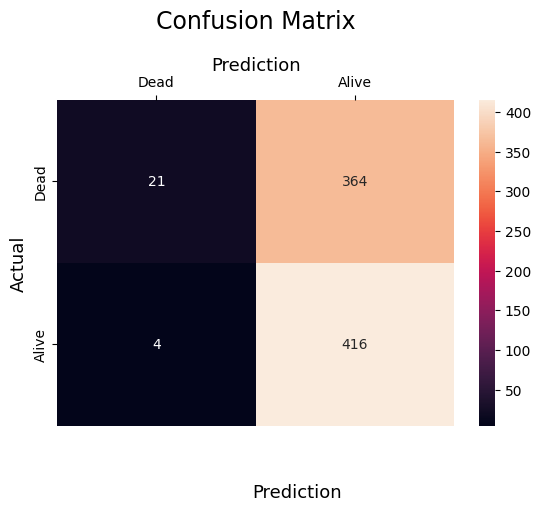

In [16]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_true=y_test["Survive Threshold"].tolist(), y_pred=y_pred_6_years)

sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    xticklabels=["Dead", "Alive"],
    yticklabels=["Dead", "Alive"],
)
plt.ylabel("Actual", fontsize=13)
plt.title("Confusion Matrix", fontsize=17, pad=20)
plt.gca().xaxis.set_label_position("top")
plt.xlabel("Prediction", fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, "Prediction", ha="center", fontsize=13)
plt.show()

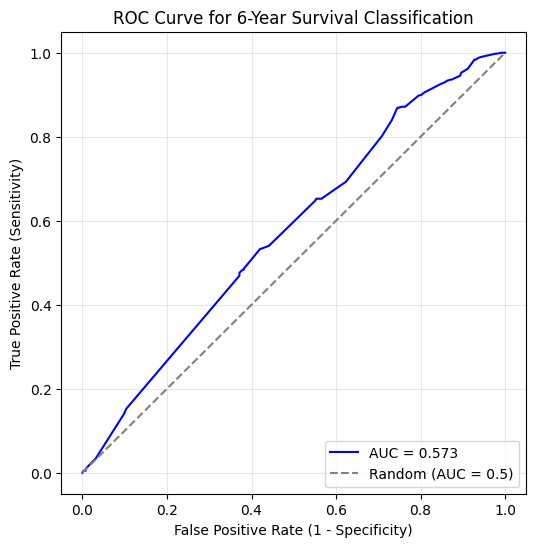

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- Compute ROC and AUC ---
y_true = y_test["Survive Threshold"]
y_score = y_pred_6_years_prob  # continuous probabilities

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

# --- Plot ROC Curve ---
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve for 6-Year Survival Classification")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


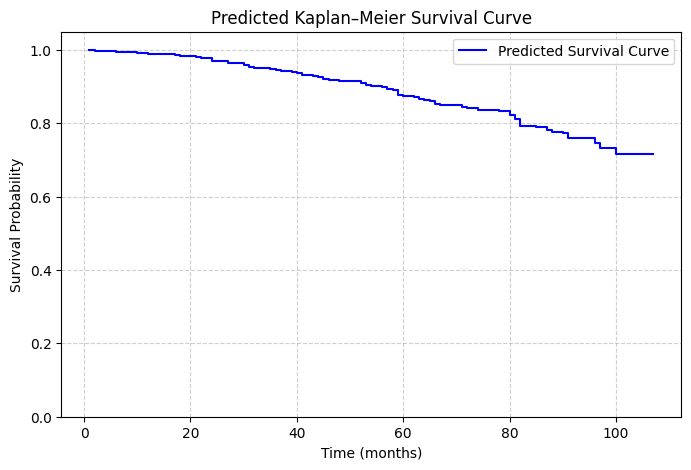

In [18]:
# y_pred is your Series
timeline = y_pred[0].index
event_prob = y_pred[0].values
survival_prob = 1 - event_prob  # Convert to survival probability

plt.figure(figsize=(8, 5))
plt.step(timeline, survival_prob, where="post", color="blue", label="Predicted Survival Curve")

plt.title("Predicted Kaplan–Meier Survival Curve")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.ylim(0, 1.05)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

## logrank_statistics
https://numiqo.com/tutorial/log-rank-test

The Log Rank Test is used in survival analysis to compare the distribution of time to event in two or more independent samples.

difference in time it takes for event to occur

**Observed – Expected.**
logrank can measure if 2 survival curves are different (e.g. compare 2 patients group: new treatments vs old treatments -> which one survive longer)

## Kaplan-Meier estimator

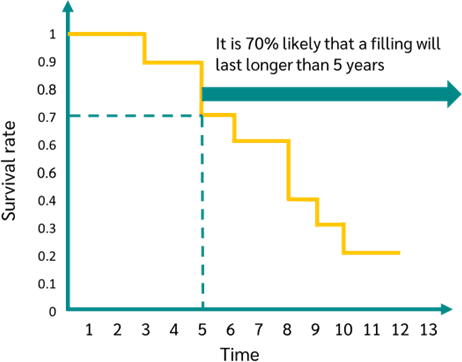

chance that X event happen at Y time

## Log Rank in RSF

If I split here, do these two groups have different survival patterns?
split with the largest log-rank value (most difference)

## RSF vs RF

The only difference between RSF and RF is that RSF use log rank as the split method, correct?

You’re right that Random Survival Forest (RSF) is conceptually the same algorithmic skeleton as Random Forest (RF) —
same ideas of:

- bootstrapping samples
- building many trees
- aggregating predictions

time-to-event data (which includes censored samples).

| Aspect                 | Random Forest (RF)                                      | Random Survival Forest (RSF)          |    |
| ---------------------- | ------------------------------------------------------- | ------------------------------------- | -- |
| Goal                   | Predict y (value/class)                                 | Predict survival function S(t         | X) |
| Handles censored data? | ❌ No                                                    | ✅ Yes                                 |    |
| Split criterion        | Variance reduction (regression) / Gini (classification) | **Log-rank test statistic**           |    |
| Leaf node output       | Mean value or class label                               | Kaplan–Meier curve                    |    |
| Final prediction       | Mean of trees                                           | Averaged survival function            |    |
| Evaluation metric      | MSE / Accuracy / R²                                     | C-index / Brier score / Log-rank test |    |

## Survival Function

The chance that X happen at Y time.

The survival function, usually written as S(t) is the probability that someone survives longer than time t

S(t) = P(T > t)
Kaplan–Meier curve visualizes

## Concordance Index
https://medium.com/analytics-vidhya/concordance-index-72298c11eac7

c-index
the proportion of concordant pairs divided by the total number of possible evaluation pairs

The concordance index (c-index) is how correct the ranking of "how long the event will happen" is, right? Does this mean that if a model has good concordance index, it can still give the completely wrong amount of time but the order will be correct even with right censored data.

How do you even compare c-index with scikit-learn accuracy_score? Actually, I don't even know what metrics the scikit-learn accuracy_score use? If one model has c-index of like 0.6 and another has f1 score of 0.8, which one is better?

## Comparing to Classification

ใช้ C-index กับ classification โดยตรงไม่ได้ เพราะ C-index ถูกออกแบบมาสำหรับ Survival Analysis ซึ่งวัดการจัดอันดับของความเสี่ยงหรืออายุรอดของแต่ละตัวอย่าง ว่าใครมีชีวิตนานกว่าหรือเสียชีวิตก่อน ในขณะที่ classification ทั่วไปแค่ทำนายว่า มีชีวิตหรือเสียชีวิต เท่านั้น ไม่สนใจลำดับเวลา

ถ้าเรากำหนดคำถามเป็น “Survival Months ≥ 6 ปี” เราสามารถใช้ C-index ได้โดยอ้อม เพราะตอนนั้นเรากำลังแปลงปัญหาให้เป็นการ predict โอกาสเสียชีวิตแบบต่อเนื่อง จาก 0 ถึงสูงสุด (max Survival Months = 107) จากนั้นเอา index 72 (6 ปี) มาดูว่า probability > 0.5 หรือไม่ เพื่อแปลงเป็น alive/dead เหมือน classification ปกติ

ตัวอย่าง Timeline ของ probability:

1.0      0.000000
2.0      0.002435
3.0      0.002527
4.0      0.003194
...
105.0    0.284814
106.0    0.284814
107.0    0.284814

## Note

y is dataframe
iloc is purely integer-location based indexing for selection by position.
y is [n_samples, 2] (survival time in first column and event in second column)


self.timeline = y.iloc[:, 1].sort_values().unique()
self.timeline should be sorted unique survival time?

Survival function is the probability something survive beyond t time
We do survival analysis to find this survival function
We can find the survival function by using the Kaplan-Meier estimator, which can estimate the survival function
To see which one survive longer, we can split them into group by using similar survival function as the criteria
But how do you compare survival function?
You use Log-Rank Test, which does statistic stuff like having null hypothesis and alternate hypothesis
Then it use some statistic calculation to prove which one is true
Or basically, to prove whether 2 survival function are the same

Is this correct?